In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import seaborn as sns
import pandas as pd

get_ipython().run_line_magic('matplotlib','inline')

path = 'C://Windows/Fonts/malgun.ttf'

if platform.system() == 'Darwin':
    rc('font', family = 'Arial Unicode Ms')
elif platform.system == 'window' :
    font_name = font_manager.Fontproperties(fname=path).get_name()
    rc('font',family=font_name)
else :
    print('unknown')

# Object
`이용자의 구독 기간, 로그인 활동, 학습 세션 참여도`와 같은 데이터 분석을 통해 학습 플랫폼 이용자의 구독 갱신 여부를 예측하는 AI 모델을 개발
***

## 자료 분석 및 전처리
| column | Description |
|------|---------------|
| user_id | 사용자의 고유 식별자 |
| subscription_duration | 사용자가 서비스에 가입한 기간 (월) |
| recent_login_time | 사용자가 마지막으로 로그인한 시간 (일) |
| average_login_time | 사용자의 일반적인 로그인 시간 |
| average_time_per_learning_session | 각 학습 세션에 소요된 평균 시간 (분) |
| monthly_active_learning_days | 월간 활동적인 학습 일수 |
| total_completed_courses | 완료한 총 코스 수 |
| recent_learning_achievement | 최근 학습 성취도 |
| abandoned_learning_sessions | 중단된 학습 세션 수 |
| community_engagement_level | 커뮤니티 참여도
| preferred_difficulty_level | ~~선호하는 난이도~~  `Low : 1, Medium : 2, High : 3`|
| subscription_type | ~~구독 유형~~  `Basic : 1, Premium : 2` |
| customer_inquiry_history | 고객 문의 이력 |
| payment_pattern | 사용자의 지난 3개월 간의 결제 패턴을 10진수로 표현한 값.<br> - 7: 3개월 모두 결제함<br> - 6: 첫 2개월은 결제했으나 마지막 달에는 결제하지 않음<br>- 5: 첫 달과 마지막 달에 결제함<br>- 4: 첫 달에만 결제함<br>- 3: 마지막 2개월에 결제함<br>- 2: 가운데 달에만 결제함<br> - 1: 마지막 달에만 결제함<br>- 0: 3개월 동안 결제하지 않음 |
| target | 사용자가 다음 달에도 구독을 계속할지 (1) 또는 취소할지 (0)를 나타냅니다.|

<br>
<code>
<접근 방향><br>
1. 데이터 해석 & EDA : 타겟 1과 0을 일단 나눠서 각 특성들과 상관 분석해보기<br>
1-1. 주어진 기본 특성<br>
1-2. 파생 특성 연구<br>
2. 이진분류 모델링
</code>

# 1차 - 실패

In [ ]:
raw_df = pd.read_csv('./raw data/train.csv')
raw_df.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [ ]:
# 결측치 갯수
raw_df.isnull().sum()

user_id                              0
subscription_duration                0
recent_login_time                    0
average_login_time                   0
average_time_per_learning_session    0
monthly_active_learning_days         0
total_completed_courses              0
recent_learning_achievement          0
abandoned_learning_sessions          0
community_engagement_level           0
preferred_difficulty_level           0
subscription_type                    0
customer_inquiry_history             0
payment_pattern                      0
target                               0
dtype: int64

In [ ]:
# label encoder할 object 종류 확인
print(raw_df['preferred_difficulty_level'].unique())
print(raw_df['subscription_type'].unique())

['Low' 'Medium' 'High']
['Basic' 'Premium']


In [ ]:
#레이블 인코딩
old_to_new_value1 = {'Low': 1, 'Medium': 2, 'High': 3}
raw_df['preferred_difficulty_level'].replace(old_to_new_value1, inplace=True)
raw_df['preferred_difficulty_level'] = raw_df['preferred_difficulty_level'].astype('int64')

old_to_new_value2 = {'Basic': 1, 'Premium': 2}
raw_df['subscription_type'].replace(old_to_new_value2, inplace=True)
raw_df['subscription_type'] = raw_df['subscription_type'].astype('int64')

## EDA

In [ ]:
pre_df=raw_df.copy()

In [ ]:
# 무의미한 데이터 삭제 (유저 아이디, 고객 문의 이력)
pre_df=pre_df.drop(['user_id','customer_inquiry_history'], axis=1)
pre_df=pre_df[['target', 'subscription_duration', 'recent_login_time', 'average_login_time','average_time_per_learning_session','monthly_active_learning_days'
                 ,'total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','preferred_difficulty_level','subscription_type'
                ,'payment_pattern']]
pre_df.head()

,target,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
0,0,13,14,14.946163,8.427187,18,16,68.360455,3,4,1,1,5
1,1,16,18,18.453224,72.646087,16,13,97.567322,2,3,2,1,6
2,1,22,1,16.195228,21.774492,13,14,94.358763,3,4,2,2,7
3,1,1,19,17.628656,42.659066,19,18,70.153228,0,3,1,1,0
4,1,4,5,21.390656,30.744287,19,10,81.917908,2,4,2,1,0


In [ ]:
#상관계수 1차
pre_df.corr()

,target,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
target,1.000000,-0.006710,-0.004184,-0.008527,0.118261,0.004876,-0.004040,0.002294,-0.019636,0.009641,0.012860,0.009824,-0.001380
subscription_duration,-0.006710,1.000000,0.014754,-0.000031,0.006324,0.002193,-0.001662,0.007875,0.014414,0.002114,-0.016938,-0.002887,-0.003704
recent_login_time,-0.004184,0.014754,1.000000,-0.006113,-0.004650,-0.015338,-0.000142,0.005768,-0.015882,-0.005486,0.008860,-0.018172,0.008737
average_login_time,-0.008527,-0.000031,-0.006113,1.000000,-0.007382,0.002294,-0.012416,-0.005967,0.013661,0.003129,-0.008765,0.008284,0.012508
average_time_per_learning_session,0.118261,0.006324,-0.004650,-0.007382,1.000000,-0.001678,0.081332,-0.008231,-0.014488,0.086485,-0.086796,0.141833,-0.002460
monthly_active_learning_days,0.004876,0.002193,-0.015338,0.002294,-0.001678,1.000000,0.004816,0.030110,-0.007512,0.000700,-0.012973,-0.017154,-0.003457
total_completed_courses,-0.004040,-0.001662,-0.000142,-0.012416,0.081332,0.004816,1.000000,-0.002416,0.012322,0.266026,-0.255945,0.406623,-0.013646
recent_learning_achievement,0.002294,0.007875,0.005768,-0.005967,-0.008231,0.030110,-0.002416,1.000000,0.002115,-0.000810,-0.004940,-0.007014,-0.003968
abandoned_learning_sessions,-0.019636,0.014414,-0.015882,0.013661,-0.014488,-0.007512,0.012322,0.002115,1.000000,0.015877,-0.023684,-0.001664,0.010299
community_engagement_level,0.009641,0.002114,-0.005486,0.003129,0.086485,0.000700,0.266026,-0.000810,0.015877,1.000000,-0.217334,0.450195,-0.015914


<Axes: >

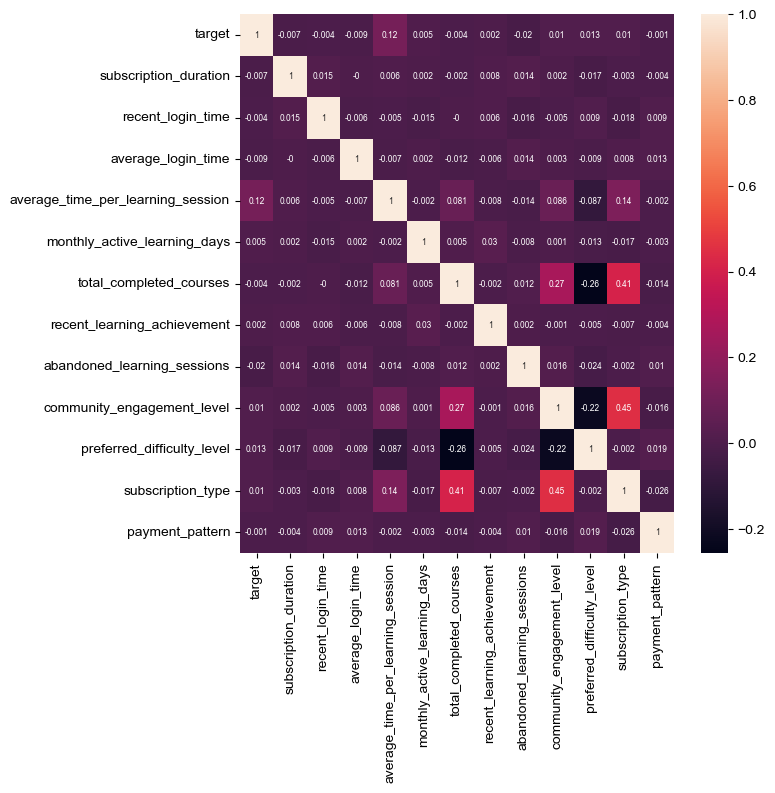

In [ ]:
plt.figure(figsize=(7, 7))
annot_font_size = 6
sns.heatmap(pre_df.corr().round(3), annot=True,annot_kws={"size": annot_font_size})

In [ ]:
#상관계수 높은 상위 5개
print("<<target과 가장 상관관계 있는 feature 상위 5>>")
print('-'*50)
print(pre_df.corr().sort_values(by='target',ascending=False)['target'][:6])

<<target과 가장 상관관계 있는 feature 상위 5>>
--------------------------------------------------
target                               1.000000
average_time_per_learning_session    0.118261
preferred_difficulty_level           0.012860
subscription_type                    0.009824
community_engagement_level           0.009641
monthly_active_learning_days         0.004876
Name: target, dtype: float64


In [ ]:
pre_df.loc[:,['average_time_per_learning_session','preferred_difficulty_level','subscription_type','community_engagement_level']]

,average_time_per_learning_session,preferred_difficulty_level,subscription_type,community_engagement_level
0,8.427187,1,1,4
1,72.646087,2,1,3
2,21.774492,2,2,4
3,42.659066,1,1,3
4,30.744287,2,1,4
...,...,...,...,...
9995,84.053558,1,2,5
9996,45.464833,2,1,3
9997,127.302411,3,1,5
9998,5.297234,1,1,5


In [ ]:
#target 1 or 0 따른 특성값 (평균)
pre_df_1=pre_df.groupby('target').mean()
pre_df_1.reset_index(drop=False, inplace=True)
pre_df_1.sort_values(by='target', ascending=False,inplace=True)
pre_df_1

,target,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
1,1,11.862720,14.985804,14.974035,60.105533,12.571866,12.216003,75.047419,3.016616,3.895628,1.708663,1.405872,3.500403
0,0,11.953959,15.057880,15.026762,46.456986,12.502236,12.246251,75.000310,3.087609,3.870560,1.687977,1.395948,3.506972


In [ ]:
#pre_df_2=선호하는 학습 레벨_2번째
pre_df_2=raw_df.groupby(['preferred_difficulty_level','target']).count().drop(['subscription_duration','recent_login_time','average_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','abandoned_learning_sessions','community_engagement_level','subscription_type','subscription_type','customer_inquiry_history','payment_pattern'], axis=1)
pre_df_2=pre_df_2.rename(columns={'user_id' : 'Count'}).unstack()
pre_df_2['0 ratio']=pre_df_2['Count'][0]/(pre_df_2['Count'][0]+pre_df_2['Count'][1])*100
pre_df_2['1 ratio']=pre_df_2['Count'][1]/(pre_df_2['Count'][0]+pre_df_2['Count'][1])*100
pre_df_2['레벨별 비구독율']=pre_df_2['Count'][0]/pre_df_2['Count'][0].sum()*100 #비구독자 전체 중 레벨별 비구독율
pre_df_2['레벨별 구독율']=pre_df_2['Count'][1]/pre_df_2['Count'][1].sum()*100 #구독자 전체 중 레벨별 구독율
pre_df_2

Count          0 ratio    1 ratio   레벨별 비구독율  \
target                         0     1                                    
preferred_difficulty_level                                                
1                           1945  3047  38.962340  61.037660  51.170745   
2                           1097  1911  36.469415  63.530585  28.860826   
3                            759  1241  37.950000  62.050000  19.968429   

                              레벨별 구독율  
target                                 
preferred_difficulty_level             
1                           49.153089  
2                           30.827553  
3                           20.019358

In [ ]:
#pre_df_3=구독형태_3번째
pre_df_3=raw_df.groupby(['subscription_type','target']).count().drop(['subscription_duration','recent_login_time','average_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','abandoned_learning_sessions','community_engagement_level','preferred_difficulty_level','customer_inquiry_history','payment_pattern'], axis=1)
pre_df_3=pre_df_3.rename(columns={'user_id' : 'subscription_type_Count'}).unstack()
pre_df_3['0 ratio']=pre_df_3['subscription_type_Count'][0]/(pre_df_3['subscription_type_Count'][0]+pre_df_3['subscription_type_Count'][1])*100
pre_df_3['1 ratio']=pre_df_3['subscription_type_Count'][1]/(pre_df_3['subscription_type_Count'][0]+pre_df_3['subscription_type_Count'][1])*100
pre_df_3['레벨별 구독']=pre_df_3['subscription_type_Count'][1]/pre_df_3['subscription_type_Count'][1].sum()*100
pre_df_3

subscription_type_Count         0 ratio   1 ratio     레벨별 구독
target                                  0     1                               
subscription_type                                                             
1                                    2296  3683  38.40107  61.59893  59.412809
2                                    1505  2516  37.42850  62.57150  40.587191

In [ ]:
#pre_df_4=커뮤니티 활동_4번째
pre_df_4=raw_df.drop(['subscription_duration','recent_login_time','average_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','preferred_difficulty_level','subscription_type','customer_inquiry_history','payment_pattern'],axis=1)
pre_df_4=pre_df_4.groupby(['target','community_engagement_level']).count()
pre_df_4.rename(columns={'user_id' : 'user_count'},inplace=True)
pre_df_4
pre_df_4.reset_index(drop=False,inplace=True)
if (pre_df_4['target'] == 1).any():
    pre_df_4['ratio of level by target'] = ((pre_df_4['user_count'] / pre_df_4.loc[pre_df_4['target'] == 1, 'user_count'].sum())*100).round(2)
else:
    pre_df_4['ratio of level by target'] = ((pre_df_4['user_count'] / pre_df_4.loc[pre_df_4['target'] == 0, 'user_count'].sum())*100).round(2)
pre_df_4['ratio of level by TTL'] = ((pre_df_4['user_count'] / pre_df_4['user_count'].sum())*100).round(2)
pre_df_4 = pre_df_4.set_index(['target','community_engagement_level'])
pre_df_4 = pre_df_4.sort_values(by=['target','community_engagement_level'], ascending=False)
pre_df_4


user_count  ratio of level by target  \
target community_engagement_level                                         
1      5                                 2867                     46.25   
       4                                 1265                     20.41   
       3                                  968                     15.62   
       2                                  751                     12.11   
       1                                  348                      5.61   
0      5                                 1697                     27.38   
       4                                  805                     12.99   
       3                                  620                     10.00   
       2                                  468                      7.55   
       1                                  211                      3.40   

                                   ratio of level by TTL  
target community_engagement_level                         
1      5                                           28.67  
       4                                           12.65  
       3                                            9.68  
       2                                            7.51  
       1                                            3.48  
0      5                                           16.97  
       4                                            8.05  
       3                                            6.20  
       2                                            4.68  
       1                                            2.11

In [ ]:
#pre_df_4_reset, 그래프 만들기 위한 코드
pre_df_4_reset=raw_df.drop(['subscription_duration','recent_login_time','average_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','preferred_difficulty_level','subscription_type','customer_inquiry_history','payment_pattern'],axis=1)
pre_df_4_reset=pre_df_4_reset.groupby(['target','community_engagement_level']).count()
pre_df_4_reset.rename(columns={'user_id' : 'user_count'},inplace=True)
pre_df_4_reset=pre_df_4_reset.reset_index()
pre_df_4_reset=pre_df_4_reset.groupby(['community_engagement_level','target']).sum().unstack()
pre_df_4_reset['0 ratio'] = ((pre_df_4['user_count'][0] / pre_df_4['user_count'][0].sum())*100).round(2)
pre_df_4_reset['1 ratio'] = ((pre_df_4['user_count'][1] / pre_df_4['user_count'][1].sum())*100).round(2)
pre_df_4_reset['TTL 0 ratio'] = ((pre_df_4['user_count'][0] / pre_df_4['user_count'].sum())*100).round(2)
pre_df_4_reset['TTL 1 ratio'] = ((pre_df_4['user_count'][1] / pre_df_4['user_count'].sum())*100).round(2)
pre_df_4_reset

user_count       0 ratio 1 ratio TTL 0 ratio  \
target                              0     1                               
community_engagement_level                                                
1                                 211   348    5.55    5.61        2.11   
2                                 468   751   12.31   12.11        4.68   
3                                 620   968   16.31   15.62        6.20   
4                                 805  1265   21.18   20.41        8.05   
5                                1697  2867   44.65   46.25       16.97   

                           TTL 1 ratio  
target                                  
community_engagement_level              
1                                 3.48  
2                                 7.51  
3                                 9.68  
4                                12.65  
5                                28.67

In [ ]:
#pre_df_5=학습일수
pre_df_5=raw_df.drop(['user_id','subscription_duration','recent_login_time','average_login_time','average_time_per_learning_session','subscription_type','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','abandoned_learning_sessions','community_engagement_level','preferred_difficulty_level','customer_inquiry_history','payment_pattern'], axis=1)
pre_df_5 = pre_df_5.groupby('target').agg(['count','sum','mean'])
pre_df_5['학습일수 ratio']=pre_df_5['monthly_active_learning_days']['sum']/pre_df_5['monthly_active_learning_days']['sum'].sum()*100
pre_df_5.sort_index(ascending=False, inplace=True)
pre_df_5

monthly_active_learning_days                   학습일수 ratio
                              count    sum       mean           
target                                                          
1                              6199  77933  12.571866  62.120777
0                              3801  47521  12.502236  37.879223

<<target과 가장 상관관계 있는 feature 상위 5>>
--------------------------------------------------
average_time_per_learning_session    0.118261
preferred_difficulty_level           0.012860
subscription_type                    0.009824
community_engagement_level           0.009641
monthly_active_learning_days         0.004876
Name: target, dtype: float64


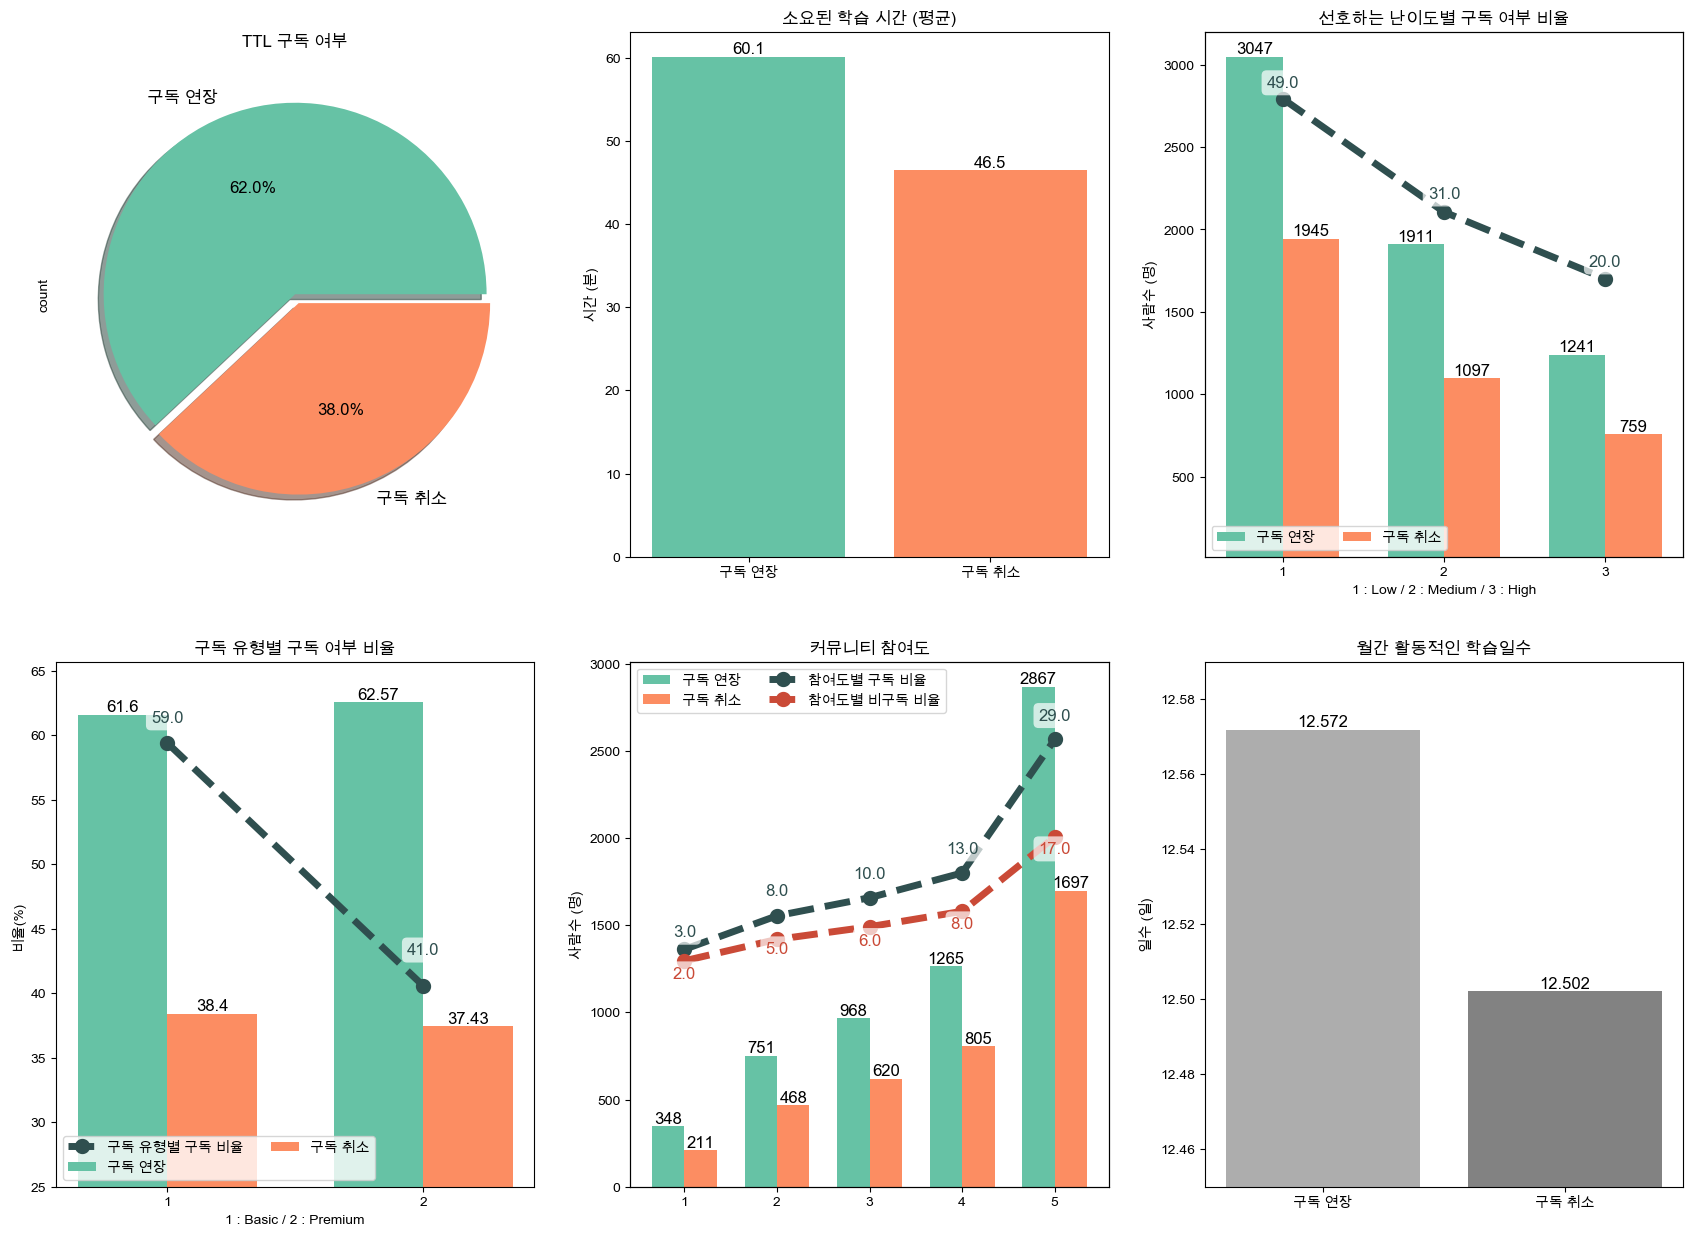

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(21, 15))

#전체 구독 여부
pre_df['target'].value_counts().plot.pie(ax=ax[0,0], labels=['구독 연장', '구독 취소'], autopct='%1.1f%%', shadow=True, explode=[0, 0.05],
                                         colors=sns.color_palette('Set2'), textprops={'fontsize': 12})
ax[0,0].set_title('TTL 구독 여부')

# 평균 소요 학습시간별
labels = ['구독 연장', '구독 취소']
values = pre_df_1['average_time_per_learning_session']
colors = sns.color_palette('Set2')
bar=ax[0,1].bar(labels, values, color=colors)
for rect in bar:
    height = rect.get_height().round(1)
    ax[0,1].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)
ax[0,1].set_ylabel('시간 (분)')
ax[0,1].set_title('소요된 학습 시간 (평균)')

# 선호 난이도별
width = 0.35
bar1 = ax[0,2].bar(pre_df_2.index - width/2, pre_df_2['Count'][1], width, label='구독 연장',color=sns.color_palette('Set2')[0])
bar2 = ax[0,2].bar(pre_df_2.index + width/2, pre_df_2['Count'][0], width, label='구독 취소',color=sns.color_palette('Set2')[1])
ax2 = ax[0, 2].twinx()
plot = ax2.plot(pre_df_2['레벨별 구독율'],marker='o',c='darkslategrey',lw=5,mew=5,ls='--',label='레벨별 구독 비율')
ax2.set_ylim(-25, 60)
ax2.get_yaxis().set_visible(False)
for rect in bar1:
    height = rect.get_height().round(2)
    ax[0,2].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)

for rect in bar2:
    height = rect.get_height().round(2)
    ax[0,2].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)

for x, y in zip(pre_df_2.index, pre_df_2['레벨별 구독율'].round(0)):
    ax2.text(x, y+2, f'{y}', ha='center', va='baseline', size=12,color='darkslategrey',bbox=dict(facecolor='white', edgecolor='none', boxstyle='round',alpha=0.7),weight='bold')

ax[0, 2].set_ylim(15)
ax[0,2].set_xlabel('1 : Low / 2 : Medium / 3 : High')
ax[0,2].set_ylabel('사람수 (명)')
ax[0,2].set_title('선호하는 난이도별 구독 여부 비율')
ax[0,2].set_xticks(pre_df_2.index)
ax[0,2].legend(loc='lower left', ncol=2, bbox_to_anchor=(0, 0))

# 구독 유형별
width = 0.35
bar1 = ax[1,0].bar(pre_df_3.index - width/2, pre_df_3['1 ratio'], width, label='구독 연장',color=sns.color_palette('Set2')[0])
bar2 = ax[1,0].bar(pre_df_3.index + width/2, pre_df_3['0 ratio'], width, label='구독 취소',color=sns.color_palette('Set2')[1])
plot = ax[1,0].plot(pre_df_3['레벨별 구독'],marker='o',c='darkslategrey',lw=5,mew=5,ls='--',label='구독 유형별 구독 비율')
for rect in bar1:
    height = rect.get_height().round(2)
    ax[1,0].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)

for rect in bar2:
    height = rect.get_height().round(2)
    ax[1,0].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)

for x, y in zip(pre_df_3.index, pre_df_3['레벨별 구독'].round(0)):
    ax[1, 0].text(x, y+2, f'{y}', ha='center', va='baseline', size=12,color='darkslategrey',bbox=dict(facecolor='white', edgecolor='none', boxstyle='round',alpha=0.7),weight=700)
ax[1, 0].set_ylim(25)
ax[1,0].set_xlabel('1 : Basic / 2 : Premium')
ax[1,0].set_ylabel('비율(%)')
ax[1,0].set_title('구독 유형별 구독 여부 비율')
ax[1,0].set_xticks(pre_df_3.index)
ax[1,0].legend(loc='lower left', ncol=2, bbox_to_anchor=(0, 0))

# 커뮤니티 참여도별
width = 0.35
bar1 = ax[1,1].bar(pre_df_4_reset.index - width/2, pre_df_4_reset['user_count'][1], width, label='구독 연장',color=sns.color_palette('Set2')[0])
bar2 = ax[1,1].bar(pre_df_4_reset.index + width/2, pre_df_4_reset['user_count'][0], width, label='구독 취소',color=sns.color_palette('Set2')[1])
ax2 = ax[1, 1].twinx()
plot1 = ax2.plot(pre_df_4_reset['TTL 1 ratio'],marker='o',c='darkslategrey',lw=5,mew=5,ls='--',label='참여도별 구독 비율')
plot2 = ax2.plot(pre_df_4_reset['TTL 0 ratio'],marker='o',c='#CA4A37',lw=5,mew=5,ls='--',label='참여도별 비구독 비율')
ax2.set_ylim(-25, 38)
ax2.get_yaxis().set_visible(False)
for x, y in zip(pre_df_4_reset.index, pre_df_4_reset['TTL 1 ratio'].round(0)):
    ax2.text(x, y + 2, f'{y}', ha='center', va='baseline', size=12, color='darkslategrey',
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.7), weight='bold')

for x, y in zip(pre_df_4_reset.index, pre_df_4_reset['TTL 0 ratio'].round(0)):
    ax2.text(x, y - 2, f'{y}', ha='center', va='baseline', size=12, color='#CA4A37',
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.7), weight='bold')

for rect in bar1:
    height = rect.get_height().round(2)
    ax[1, 1].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)

for rect in bar2:
    height = rect.get_height().round(2)
    ax[1, 1].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)
ax[1,1].set_ylabel('사람수 (명)')
ax[1,1].set_title('커뮤니티 참여도')
ax[1,1].set_xticks(pre_df_4_reset.index)
lines, labels = ax[1, 1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[1, 1].legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, bbox_to_anchor=(0, 1))

# 월간 활동적인 학습일수
labels = ['구독 연장', '구독 취소']
values = pre_df_5['monthly_active_learning_days']['mean']
colors = sns.color_palette('Greys')[2:]
bar=ax[1,2].bar(labels, values, color=colors)
for rect in bar:
    height = rect.get_height().round(3)
    ax[1,2].text(rect.get_x() + rect.get_width()/2.0, height, f'{height}', ha='center', va='bottom', size=12)
ax[1,2].set_ylabel('일수 (일)')
ax[1,2].set_title('월간 활동적인 학습일수')
y_start = 12.45
y_end = 12.59
ax[1, 2].set_ylim(y_start, y_end)


print("<<target과 가장 상관관계 있는 feature 상위 5>>")
print('-'*50)
print(pre_df.corr().sort_values(by='target',ascending=False)['target'][1:6])

plt.show()

In [ ]:
pre_df_1_1=pre_df.loc[pre_df['target']==1,['average_time_per_learning_session']]
pre_df_1_0=pre_df.loc[pre_df['target']==0,['average_time_per_learning_session']]
print(pre_df_1_1)
print(pre_df_1_0)

      average_time_per_learning_session
1                             72.646087
2                             21.774492
3                             42.659066
4                             30.744287
6                            116.455949
...                                 ...
9994                          88.757610
9995                          84.053558
9996                          45.464833
9997                         127.302411
9998                           5.297234

[6199 rows x 1 columns]
      average_time_per_learning_session
0                              8.427187
5                             34.034189
10                           135.256834
11                           117.134599
14                             2.712124
...                                 ...
9980                          40.075854
9983                           6.047050
9987                         160.590536
9989                          21.655545
9999                          28.120031

[3801 rows x 1

## 머신러닝

In [ ]:
# 레이블 라벨링 함수 설정
def make_label(df) :
    if df['preferred_difficulty_level'].dtype =='object' :
        old_to_new_value1 = {'Low': 1, 'Medium': 2, 'High': 3}
        df['preferred_difficulty_level'].replace(old_to_new_value1, inplace=True)
        df['preferred_difficulty_level'] = df['preferred_difficulty_level'].astype('int64')
    elif df['subscription_type'].dtype =='object' :
        old_to_new_value2 = {'Basic': 1, 'Premium': 2}
        df['subscription_type'].replace(old_to_new_value2, inplace=True)
        df['subscription_type'] = df['subscription_type'].astype('int64')
    return (df)

In [ ]:
#데이터 로드 & 전처리
raw_df = pd.read_csv('./raw data/train.csv')
labeled_df=make_label(raw_df)
labeled_df=labeled_df.drop(['user_id','customer_inquiry_history'], axis=1)
labeled_df=labeled_df[['target', 'subscription_duration', 'recent_login_time', 'average_login_time','average_time_per_learning_session','monthly_active_learning_days'
                 ,'total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','preferred_difficulty_level','subscription_type'
                ,'payment_pattern']]
labeled_df.head()

,target,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,payment_pattern
0,0,13,14,14.946163,8.427187,18,16,68.360455,3,4,1,Basic,5
1,1,16,18,18.453224,72.646087,16,13,97.567322,2,3,2,Basic,6
2,1,22,1,16.195228,21.774492,13,14,94.358763,3,4,2,Premium,7
3,1,1,19,17.628656,42.659066,19,18,70.153228,0,3,1,Basic,0
4,1,4,5,21.390656,30.744287,19,10,81.917908,2,4,2,Basic,0


#### One Hot Encoding
한 데이터은 동시에 한 가지 유형만이 될 수 있어 매우 직관적이다. 따라서 데이터가 서로 관련이 없고 명확하지 않은 경우 활용된다. 또한 문자 데이터 같은 경우에는 숫자로 변환을 해야 데이터를 다루기가 쉽기 때문이다.<br>
(출처 : https://velog.io/@sty0507/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%9B%90%ED%95%AB-%EC%9D%B8%EC%BD%94%EB%94%A9)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split

raw_df = pd.read_csv('./raw data/train.csv')
labeled_df=raw_df.drop('customer_inquiry_history', axis=1)
selected_columns = ['user_id', 'target', 'subscription_duration', 'recent_login_time', 'average_login_time',
                     'average_time_per_learning_session', 'monthly_active_learning_days',
                     'total_completed_courses', 'recent_learning_achievement',
                     'abandoned_learning_sessions', 'community_engagement_level', 'preferred_difficulty_level',
                     'subscription_type', 'payment_pattern']
labeled_df = labeled_df[selected_columns]

ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoded_array = ohe.fit_transform(labeled_df[['preferred_difficulty_level', 'subscription_type']])


/Users/soo/miniforge3/envs/ds_study/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# 정규화
scaler = StandardScaler()
scaled_array = scaler.fit_transform(encoded_array)

In [ ]:
# 특성과 타겟 분리
X = scaled_array
y = labeled_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#교차검증
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.6195 0.62   0.62   0.62   0.62  ]
Mean Accuracy: 0.6199000000000001


In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.621


In [ ]:
from sklearn.metrics import roc_curve, auc
val_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print("* 검증 데이터(Validation) Macro F1 성능 : ",val_f1)
print(classification_report(y_test, y_pred, zero_division=0))
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("* ROC AUC Score:", roc_auc)

* 검증 데이터(Validation) Macro F1 성능 :  0.38309685379395436
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       758
           1       0.62      1.00      0.77      1242

    accuracy                           0.62      2000
   macro avg       0.31      0.50      0.38      2000
weighted avg       0.39      0.62      0.48      2000

* ROC AUC Score: 0.5


In [ ]:
test_data = pd.read_csv('./raw data/test.csv')
test_labeled_df=test_data.drop('customer_inquiry_history', axis=1)
selected_columns = ['user_id', 'subscription_duration', 'recent_login_time', 'average_login_time',
                     'average_time_per_learning_session', 'monthly_active_learning_days',
                     'total_completed_courses', 'recent_learning_achievement',
                     'abandoned_learning_sessions', 'community_engagement_level',
                     'preferred_difficulty_level', 'subscription_type', 'payment_pattern']
test_labeled_df = test_labeled_df[selected_columns]

test_labeled_encoded = ohe.transform(test_labeled_df[['preferred_difficulty_level', 'subscription_type']])
test_labeled_scaled = scaler.transform(test_labeled_encoded)
prediction = model.predict(test_labeled_scaled)


In [ ]:
prediction

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
sub_df = pd.read_csv('./raw data/sample_submission.csv')
sub_df['target'] = prediction
sub_df.head()

,user_id,target
0,0001d6e9,1
1,0002c77d,1
2,0002df5b,1
3,000b6068,1
4,00184a0c,1


# 2차